# Library & Data

Libraries

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.model_selection import cross_validate,cross_val_score,LeaveOneOut
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_auc_score
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.model_selection import cross_validate,cross_val_score,LeaveOneOut
from sklearn.metrics import recall_score

Data

In [33]:
def get_standardizable_features(dataframe: pd.DataFrame):
    return [x for x in dataframe.columns if x.startswith('HR')]


scaler = StandardScaler()

# Load data.
hr_data = pd.read_csv('HR_data_transformed.csv', sep=',', header=0)
hr_data.drop(['Unnamed: 0'], axis=1, inplace=True)
tmp = hr_data.copy()

# Transform data
transform_data = True
if transform_data:
    to_log_transform = ['HR_std']
    for col in to_log_transform:
        tmp[col] = np.log(tmp[col])
        tmp[col].name = col + '_log'
        tmp.rename(columns={col: col + '_log'}, inplace=True)
    to_inverse_transform = ['HR_AUC']
    for col in to_inverse_transform:
        tmp[col] = 1 / tmp[col]
        tmp[col].name = col + '_inverse'
        tmp.rename(columns={col: col + '_inverse'}, inplace=True)
    to_boxcox_transform = ['HR_Max']
    for col in to_boxcox_transform:
        tmp[col], _ = boxcox(tmp[col] - tmp[col].min() + 1)
        tmp[col].name = col + '_boxcox'
        tmp.rename(columns={col: col + '_boxcox'}, inplace=True)

# Standardize data
standardized = True
if standardized:
    cols = get_standardizable_features(tmp)
    tmp[cols] = scaler.fit_transform(tmp[cols])

working_dataset = tmp.copy()

# filtering off the non-HR features
filtered_hr_data = working_dataset.copy()
dropped = ["HR_Median","HR_Min","Round", "Phase", "Individual", "Puzzler", "Cohort"]

for column_to_drop in dropped:
    filtered_hr_data.drop(column_to_drop, axis=1, inplace=True)

X = filtered_hr_data.iloc[:, :-1]  # All columns except the last one
Y = filtered_hr_data.iloc[:, -1]  # Last column
y = Y

filtered_hr_data.head()


,HR_Mean,HR_std_log,HR_Max_boxcox,HR_AUC_inverse,Frustrated
0,0.261529,-0.592147,-0.269578,-0.009167,1
1,-0.672305,-1.034575,-0.863799,0.305442,5
2,-0.352626,-0.632567,-0.609914,0.400355,0
3,0.388771,-0.292721,-0.121668,-0.650189,1
4,0.175560,0.329823,0.311460,-0.289564,5


# Correlation

Correlation Heatmap of all HR features

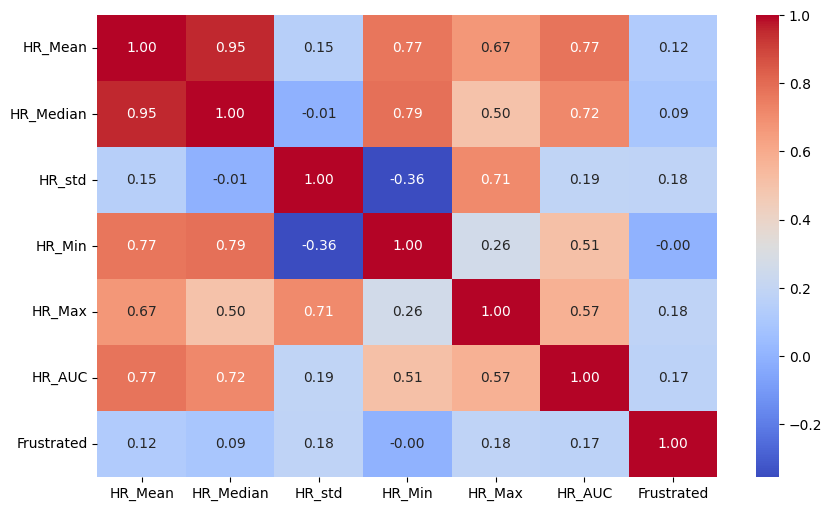

In [34]:
# Now we will try checking the correlation of the features by viewing their correlation coefficients // Spearman Correlation
filtered_hr_data = hr_data.copy()
dropped = ["Round", "Phase", "Individual", "Puzzler", "Cohort"]

for column_to_drop in dropped:
    filtered_hr_data.drop(column_to_drop, axis=1, inplace=True)
# Assuming hr_data is your DataFrame
cor, p_values = spearmanr(filtered_hr_data)

plt.figure(figsize=(10, 6))
sns.heatmap(cor, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=filtered_hr_data.columns, yticklabels=filtered_hr_data.columns)
plt.show()
# if two features are correlated, the model only needs one, as the second does not add additional information  correlation_heatmap.PNG

Correlation Heatmap without Median & Min

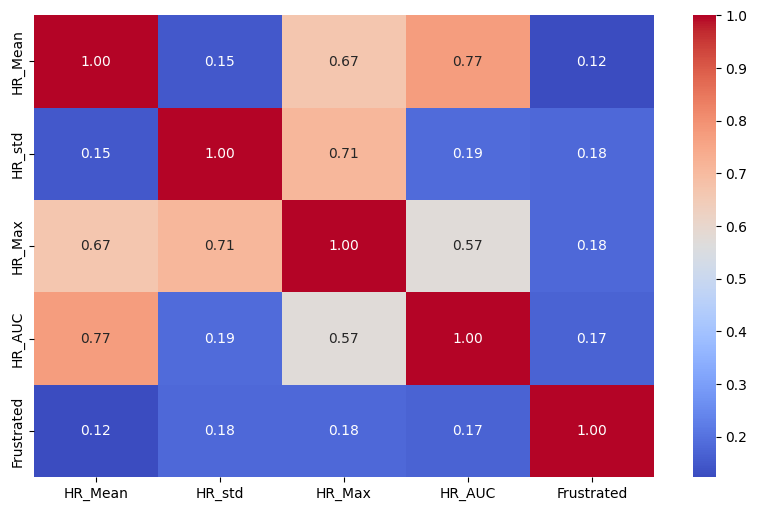

In [35]:
# Now we will try checking the correlation of the features by viewing their correlation coefficients // Spearman Correlation
filtered_hr_data = hr_data.copy()
dropped = ["HR_Min","HR_Median","Round", "Phase", "Individual", "Puzzler", "Cohort"]

for column_to_drop in dropped:
    filtered_hr_data.drop(column_to_drop, axis=1, inplace=True)
# Assuming hr_data is your DataFrame
cor, p_values = spearmanr(filtered_hr_data)

plt.figure(figsize=(10, 6))
sns.heatmap(cor, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=filtered_hr_data.columns, yticklabels=filtered_hr_data.columns)
plt.show()
# if two features are correlated, the model only needs one, as the second does not add additional information  correlation_heatmap.PNG

# Models & LOOCV

Majority Class Classifier LOOCV

In [36]:
%%capture
accuracyArray = []

# Initialize confusion matrix
overall_conf_matrix = np.zeros((2, 2), dtype=int)

for i in range(len(Y)):
    X_train = X.drop(i)
    X_test = X.loc[i].values.reshape(1, -1)
    y_train = Y.drop(i)

    # Use majority vote as the prediction
    majority_vote_prediction = y_train.mode().iloc[0]
    
    # Quick and easy evaluation
    accuracy = accuracy_score([Y.iloc[i]], [majority_vote_prediction])
    accuracyArray.append(accuracy)

average_accuracy = np.mean(accuracyArray)

In [37]:
print("Average Accuracy:", (average_accuracy)*100)

Average Accuracy: 26.785714285714285


Random Forest Classifier LOOCV

In [38]:
%%capture
model = RandomForestClassifier()
accuracyArray = []
# Initialize confusion matrix
overall_conf_matrix = np.zeros((2, 2), dtype=int)
for i in range(len(Y)):
    X_train = X.drop(i)
    X_test = X.loc[i].values.reshape(1, -1)
    y_train = Y.drop(i)
    y_test = Y.iloc[i]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test).round().astype(int)

    conf_matrix = confusion_matrix([y_test], y_pred)
    overall_conf_matrix += conf_matrix

    # Quick and easy evaluation
    accuracy = accuracy_score([y_test], y_pred)  # Convert scalar y_test to a list
    accuracyArray.append(accuracy)

average_accuracy = np.mean(accuracyArray)

In [39]:
print("Average Accuracy:", (average_accuracy)*100)

Average Accuracy: 20.238095238095237


# Confusion Matrix on grouped data (via LOOCV)

Grouping the data

In [40]:
threshold = 5
Y_grouped = (Y >= threshold).astype(int)
Y = Y_grouped
filtered_hr_data['Frustrated'] = Y_grouped

Majority Class Classifier

In [41]:
%%capture
# Initialize confusion matrix
TP_majority = 0
FP_majority = 0
TN_majority = 0
FN_majority = 0

for i in range(len(Y)):
    X_train_majority = X.drop(i)
    y_train_majority = Y.drop(i)

    # Use majority vote as the prediction
    majority_vote_prediction_majority = y_train_majority.mode().iloc[0]

    # Update confusion matrix for majority class classifier
    if Y.iloc[i] == 1 and majority_vote_prediction_majority == 1:
        TP_majority += 1
    elif Y.iloc[i] == 0 and majority_vote_prediction_majority == 1:
        FP_majority += 1
    elif Y.iloc[i] == 0 and majority_vote_prediction_majority == 0:
        TN_majority += 1
    elif Y.iloc[i] == 1 and majority_vote_prediction_majority == 0:
        FN_majority += 1

In [42]:
print("Average Accuracy:", (TN_majority+TP_majority)/len(Y)*100)
print("Confusion Matrix:")
print(f"Confusion Matrix:\n[[{TN_majority}  {FP_majority}]\n [{FN_majority}  {TP_majority}]]")
print("Length of Y:", len(Y))

Average Accuracy: 85.71428571428571
Confusion Matrix:
Confusion Matrix:
[[144  0]
 [24  0]]
Length of Y: 168


Random Forest Classifier

In [43]:
%%capture
model = RandomForestClassifier()
accuracyArray = []
# Initialize confusion matrix
TP = 0
FP = 0
TN = 0
FN = 0

for i in range(len(Y)):
    X_train = X.drop(i)
    X_test = X.loc[i].values.reshape(1, -1)
    y_train = Y.drop(i)
    y_test = Y.iloc[i]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test).round().astype(int)

    # Update confusion matrix
    if y_test == 1 and y_pred == 1:
        TP += 1
    elif y_test == 0 and y_pred == 1:
        FP += 1
    elif y_test == 0 and y_pred == 0:
        TN += 1
    elif y_test == 1 and y_pred == 0:
        FN += 1
    

In [44]:
print("Average Accuracy:", (TN+TP)/len(Y)*100)
print("Confusion Matrix:")
print(f"Confusion Matrix:\n[[{TN}  {FP}]\n [{FN}  {TP}]]")
print("Length of Y:", len(Y))

Average Accuracy: 83.33333333333334
Confusion Matrix:
Confusion Matrix:
[[140  4]
 [24  0]]
Length of Y: 168
